In [97]:
import requests
from tqdm import tqdm
from requests.auth import HTTPBasicAuth
from pprint import pprint
import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.patheffects as path_effects
import matplotlib.colors as mcolors
from matplotlib import cm
import matplotlib.font_manager as fm
from matplotlib import rcParams

from PIL import Image
import urllib
import matplotlib.font_manager as fm
from highlight_text import fig_text

import os
import math

username = 'qjpuw3t-yf3bvhgms-8d0gift-bm2fprvs4z'
token =  '7*.w$Ivko$FpRsbumn0gF(0Kc5yMAI'

base_url = 'https://apirest.wyscout.com/v3{}'


In [98]:
footMobId = {'Fiorentina': 8535,
 'Milan': 8564,
 'Atalanta': 8524,
 'Bologna': 9857,
 'Cremonese': 7801,
 'Empoli': 8534,
 'Hellas Verona': 9876,
 'Internazionale': 8636,
 'Juventus': 9885,
 'Lazio': 8543,
 'Lecce': 9888,
 'Monza': 6504,
 'Roma': 8686,
 'Napoli': 9875,
 'Salernitana': 6480,
 'Sampdoria': 9882,
 'Sassuolo': 7943,
 'Spezia': 9881,
 'Torino': 9804,
 'Udinese': 8600,
 'Genoa': 10233,
 'Cagliari': 8529,
 'Venezia': 7881,
 'Benevento': 6266,
 'Crotone': 9884,
 'Parma': 10167,
 'Brescia': 9858,
 'Spal': 8547}

ColorCode = {
 'Fiorentina': "#482E92",
 'Milan': "#FB090B",
 'Atalanta': "#1E71B8",
 'Bologna': "#1A2F48",
 'Cremonese': "#AD1919",
 'Empoli': "#00579C",
 'Hellas Verona': "#005395",
 'Internazionale': "#005CA8",
 'Juventus': "#000000",
 'Lazio': "#87D8F7",
 'Lecce': "#ED1B23",
 'Monza': "#ED1B23",
 'Roma': "#F0BC42",
 'Napoli': "#003C82",
 'Salernitana': "#8A1E03",
 'Sampdoria': "#1B5497",
 'Sassuolo': "#00A752",
 'Spezia': "#000000",
 'Torino': "#8A1E03",
 'Udinese': "#000000"
}

Players, Teams 2022/23

In [99]:
SerieA = 524

A_Season_21_22 = 187528
A_Season_20_21 = 186353
A_Season_19_20 = 186353
A_Season_22_23 = 188160

available_seasons = [(SerieA,A_Season_22_23)]

players,teams = [],[]
players_season = {}

for season in available_seasons:
    api_url = base_url.format(f'/seasons/{season[1]}/teams')
    response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
    if response.ok:
        team = response.json()['teams']
        teams+=team


team_name = {}
for team in teams:
  team_name[team['wyId']] = team['name']

match events

In [100]:
events = []
matches = []
#gameweek = 1

for season in available_seasons:
    
    api_url = base_url.format(f'/competitions/{SerieA}/matches')
    response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
    if response.ok:
      season_matches = response.json()['matches']
    else:
      print("errore")
      break
    last_season_matches = []
    for match in season_matches:
      if match['seasonId'] == season[1]:
        last_season_matches.append(match)
    for m in tqdm(last_season_matches):
        api_url = base_url.format('/matches/%s/events'%(m['matchId']))
        response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
        if response.ok:
            match_events = response.json()['events']
            events += match_events

        
        api_url = base_url.format('/matches/%s'%(m['matchId']))
        response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
        if response.ok:
            matches.append( response.json())

    for team in team_name.keys():
      api_url = base_url.format(f'/teams/{team}/squad?seasonId={season[1]}')
      response = requests.get(api_url, auth=HTTPBasicAuth(username, token))
      if response.ok:
        player = response.json()['squad']
        players+=player
      for p in player:
          players_season[p['wyId']] = season
    
        
player_name = {}
for p in players:
  player_name[p['wyId']] = [p['shortName'], p['role']['code3']]

team_name = {}
for t in teams:
  team_name[t['wyId']] = t['name']

match_name = {}
match_gameweek = {}
for m in matches:
  match_name[m['wyId']] = m['label']
  match_gameweek[m['wyId']] = m['gameweek']


100%|██████████| 40/40 [01:49<00:00,  2.73s/it]


In [101]:
ev_loc = []
#V3
# SHOTS
for i,ev in enumerate(events):
  doc1 = {}
  if ev['shot'] != None:
    doc1['matchId'] = ev['matchId']
    doc1['match'] = match_name[ev['matchId']]
    doc1['matchPeriod'] = ev['matchPeriod']
    if doc1['matchPeriod']=="1H":
      doc1['min'] = ev['minute'] if ev['minute'] < 46 else 45
      doc1['sec'] = ev['second'] if ev['minute'] < 46 else 0
    else:
      doc1['min'] = ev['minute'] if ev['minute'] < 91 else 90
      doc1['sec'] = ev['second'] if ev['minute'] < 91 else 0
    doc1['playerId'] = ev['player']['id']
    doc1['player'] = ev['player']['name']
    doc1['role'] =  ev['player']['position']
    doc1['teamName'] = team_name[ev['team']['id']]
    doc1['teamId'] = footMobId[doc1['teamName']]
    doc1['teamColor'] = ColorCode[doc1['teamName']]
    doc1['eventName'] = "shot"
    doc1['bodyPart'] = ev['shot']['bodyPart']
    doc1['onTarget'] = ev['shot']['onTarget']
    doc1['isGoal'] = ev['shot']['isGoal']
    doc1['goalZone'] = ev['shot']['goalZone']
    doc1['xG'] = ev['shot']['xg']
    doc1['PSxG'] = ev['shot']['postShotXg']
    if (doc1['isGoal']):
      doc1['eventType'] = 'Goal'
    elif (ev['shot']['goalkeeper'] != None):
      doc1['eventType'] = 'AttemptSaved'
    else:
      doc1['eventType'] = 'Miss'
    if ev['shot']['goalkeeper'] != None:
      doc1['GKId'] = int(ev['shot']['goalkeeper']['id'])
      doc1['GKname'] = ev['shot']['goalkeeper']['name']
    doc1['x'] = ev['location']['x']
    doc1['y'] = ev['location']['y']
    if (doc1['match'].split()[0] == doc1['teamName']):
      doc1['venue'] = 'H'
    else:
      doc1['venue'] = 'A'
    ev_loc.append(doc1)
  elif (ev['type']['primary'] == "own_goal"):
    doc1['matchId'] = ev['matchId']
    doc1['match'] = match_name[ev['matchId']]
    doc1['matchPeriod'] = ev['matchPeriod']
    doc1['min'] = ev['minute']
    doc1['sec'] = ev['second']
    doc1['playerId'] = ev['player']['id']
    doc1['player'] = ev['player']['name']
    doc1['role'] =  ev['player']['position']
    doc1['teamName'] = team_name[ev['opponentTeam']['id']]
    doc1['teamId'] = footMobId[doc1['teamName']]
    doc1['teamColor'] = ColorCode[doc1['teamName']]
    doc1['eventName'] = "own-goal"
    doc1['eventType'] = 'Goal'
    doc1['bodyPart'] = "NA"
    doc1['onTarget'] = True
    doc1['isGoal'] = True
    doc1['goalZone'] = "NA"
    doc1['xG'] = 0
    doc1['PSxG'] = 0
    #if ev['shot']['goalkeeper'] != None:
    #  doc1['GKId'] = int(ev['shot']['goalkeeper']['id'])
    #  doc1['GKname'] = ev['shot']['goalkeeper']['name']
    doc1['x'] = ev['location']['x']
    doc1['y'] = ev['location']['y']
    if (doc1['match'].split()[0] == doc1['teamName']):
      doc1['venue'] = 'H'
    else:
      doc1['venue'] = 'A'
    ev_loc.append(doc1)


df = pd.DataFrame(ev_loc)
match_gameweek_s = pd.Series(match_gameweek,name='gameweek')
match_gameweek_df = match_gameweek_s.to_frame()
match_gameweek_df.reset_index(inplace=True)
match_gameweek_df.rename(columns={'index':'matchId'}, inplace=True)
df_complete = pd.merge(df, match_gameweek_df, how='left')


In [6]:
#import json
#json.dump(events,  open("./data/shots_SerieA_2022_2023_1_4.json","w"))

In [102]:
font_path = "../Fonts"
for x in os.listdir(font_path):
    for y in os.listdir(f'{font_path}/{x}'):
        if y.split('.')[-1] == 'ttf':
            fm.fontManager.addfont(f'{font_path}/{x}/{y}')
            try:
                fm.FontProperties(weight=y.split('-')[-1].split('.')[0].lower(), fname=y)
            except Exception as e:
                print(f'Font {y} could not be added.')
                continue

rcParams['font.family'] = 'DMSans'

Font DMSans-BoldItalic.ttf could not be added.
Font DMSans-Italic.ttf could not be added.
Font DMSans-MediumItalic.ttf could not be added.
Font Karla-BoldItalic.ttf could not be added.
Font Karla-Italic.ttf could not be added.


In [103]:
df_complete['min'] = df_complete['min'].astype(int)
df_complete['xG'] = df_complete['xG'].astype(float)

In [104]:
cond = df_complete['eventType']=='Goal'
df_complete['Goal'] = cond + 0

### Overall View

In [105]:
### All the game so far
df_complete1 = df_complete.groupby(['teamName', 'teamId']).agg(xG_sum=pd.NamedAgg(column='xG', aggfunc='sum'),
            xG_ave=pd.NamedAgg(column='xG', aggfunc='mean'),
            xG_max=pd.NamedAgg(column='xG', aggfunc='max'),
            GoalS=pd.NamedAgg(column='Goal', aggfunc='sum')).reset_index()
df_complete1['GS-xG'] = df_complete1['GoalS']-df_complete1['xG_sum']

df_final = df_complete1.sort_values('GS-xG', ascending=True)
df_final.reset_index(inplace=True, drop=True)

In [106]:
df_final

,teamName,teamId,xG_sum,xG_ave,xG_max,GoalS,GS-xG
0,Sampdoria,9882,5.502929,0.112305,0.6953,1,-4.502929
1,Roma,8686,8.892202,0.138941,0.6492,6,-2.892202
2,Monza,6504,4.605814,0.115145,0.6556,2,-2.605814
3,Fiorentina,8535,5.391813,0.088390,0.3554,3,-2.391813
4,Sassuolo,7943,5.379637,0.096065,0.7600,3,-2.379637
5,Internazionale,8636,10.985353,0.156934,0.8056,9,-1.985353
6,Bologna,9857,4.850115,0.107780,0.7600,3,-1.850115
7,Torino,9804,6.757481,0.160892,0.7516,5,-1.757481
8,Empoli,8534,3.575171,0.079448,0.3192,2,-1.575171
9,Salernitana,6480,6.327310,0.124065,0.7271,5,-1.327310


In [107]:
gradient = [
    '#de6f57',
    '#d5724d',
    '#cb7644',
    '#c0783e',
    '#b57b38',
    '#a97d35',
    '#9e7f34',
    '#928134',
    '#878137',
    '#7c823a',
    '#71823f',
    '#668244',
    '#5c814a',
    '#528050',
    '#497f56',
    '#407d5b',
    '#387b61',
    '#317966',
    '#2c776a',
    '#29756e',
    '#287271',
]
soc_cm = mcolors.LinearSegmentedColormap.from_list('SOC', gradient, N=50)
cm.register_cmap(name='SOC', cmap=soc_cm)

C:\Users\fgron\AppData\Local\Temp\ipykernel_25944\3465554131.py:25: UserWarning: Trying to register the cmap 'SOC' which already exists.
  cm.register_cmap(name='SOC', cmap=soc_cm)


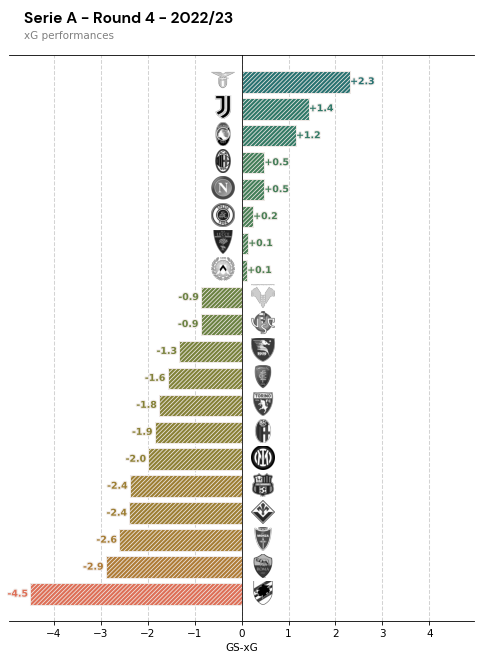

In [108]:
data = df_final

def add_logo_on_ax(ax, team_id, bw = True):
    '''
    This function adds the logo of a football team on a specific
    axes based on the Fotmob team ID.
    Args:
        - ax (object): the matplotlib axes object.
        - team_id (int): the Fotmob team ID.
        - bw (bool): whether to add the logo as black & white or with color.
    '''
    fotmob_url = 'https://images.fotmob.com/image_resources/logo/teamlogo/'
    club_icon = Image.open(urllib.request.urlopen(f'{fotmob_url}{team_id:.0f}.png')).convert('LA')
    if bw:
        club_icon = club_icon.convert('LA')
    ax.imshow(club_icon)
    ax.axis("off")
    return ax

fig = plt.figure(figsize=(8,10), dpi=75)
ax = plt.subplot()
# -- Axes settings --------------------------------
ax.spines['left'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.grid(ls='--', lw=1, color='lightgrey', axis='x')
ax.yaxis.set_ticks([])
# -- Hatches --------------------------------------
plt.rcParams['hatch.linewidth'] = 0.75
# -- Axes limits and tick positions ---------------
# Ensure symmetrical limits on the x-axis
max_ = max(abs(data['GS-xG'].min()), data['GS-xG'].max())
# Add 10% margin of the limit to the x-axis
max_ = max_*(1.1)
ax.set_xlim(-max_, max_)
ax.set_ylim(-1, data.shape[0])
ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax.set_xlabel('GS-xG', size=10)
# -- Bar Chart -------------------------------------
# Declare CMAP & Normalization
norm = mcolors.Normalize(vmin=data['GS-xG'].min(),vmax=data['GS-xG'].max())
cmap = plt.get_cmap('SOC')
ax.barh(
    data.index, data['GS-xG'],
    hatch='//////', ec='#efe9e6',
    color = cmap(norm(data['GS-xG'])),
    zorder=3
)
ax.plot(
    [0,0],
    [ax.get_ylim()[0], ax.get_ylim()[1]],
    color='black',
    lw=.75,
    zorder=3
)

# -- Annotations -----------------------------------
# -- Transforms for the placement of the logo ax ---
DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))
for index, x in enumerate(data['GS-xG']):
    if x < 0:
        sign_offset = -1
        offset_logo = .20
        sign_text = ''
    else:
        sign_offset = 1
        offset_logo = .65
        sign_text = '+'
    text_ = ax.annotate(
        xy=(x, index),
        xytext=(sign_offset*12,0),
        text=f'{sign_text}{x:.1f}',
        color= cmap(norm(x)),
        size=9,
        weight='bold',
        ha='center',
        va='center',
        textcoords='offset points'
    )
    text_.set_path_effects([
        path_effects.Stroke(
            linewidth=2, 
            foreground='#efe9e6'
        ), 
        path_effects.Normal()
    ])

    # -- Add the logo
    team_id = data['teamId'].iloc[index]
    ax_coords = DC_to_NFC([sign_offset*(-1)*offset_logo, index - 0.5])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.04, 0.04], anchor = "C")
    add_logo_on_ax(logo_ax, team_id, True)


    # -- Figure title and arrows --------------------------------
position_negative = data[data['GS-xG'] < 0].index.max()

position_x_negative = math.floor(-max_*(.85))
position_x_positive = math.ceil(max_*(.85))

ax.annotate(
    xy=(position_x_negative,position_negative + .5),
    xytext=(position_x_negative,ax.get_ylim()[1]),
    text='',
    arrowprops=dict(arrowstyle='<-',color='gray')
)
ax.annotate(
    xy=(position_x_positive,position_negative),
    xytext=(position_x_positive,ax.get_ylim()[0] + .2),
    text='',
    arrowprops=dict(arrowstyle='<-',color='gray')
)
mid_point_positive = (position_negative + ax.get_ylim()[1])/2
mid_point_negative = (position_negative + ax.get_ylim()[0])/2

ax.annotate(
    xy=(position_x_negative,mid_point_positive),
    text='xG over performers',
    rotation=90,
    xytext=(-5,0),
    textcoords='offset points',
    ha='center',
    va='center',
    size=12
)
ax.annotate(
    xy=(position_x_positive,mid_point_negative),
    text='xG under performers',
    rotation=-90,
    xytext=(5,0),
    textcoords='offset points',
    ha='center',
    va='center',
    size=12
)

fig_text(
    x = 0.15, y = .92, 
    s = 'Serie A - Round 4 - 2022/23',
    va = 'bottom', ha = 'left',
    fontsize = 15, color = 'black', font = 'DM Sans', weight = 'bold'
)

fig_text(
    x = 0.15, y = 0.9, 
    s = 'xG performances',
    va = 'bottom', ha = 'left',
    fontsize = 10, color = 'gray'
)

plt.savefig(
	"figures/SerieA_4_22_23_xG_performance_1.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.show()

In [95]:
data_xg = data[['teamName', 'teamId','xG_sum']]
data_xg_sorted = data_xg.sort_values('xG_sum', ascending=False)
data_xg_sorted.reset_index(inplace=True, drop=True)

xg_2223_avg = data_xg_sorted['xG_sum'].mean()
X_2223=data_xg_sorted.index
height_2223 = data_xg_sorted['xG_sum']

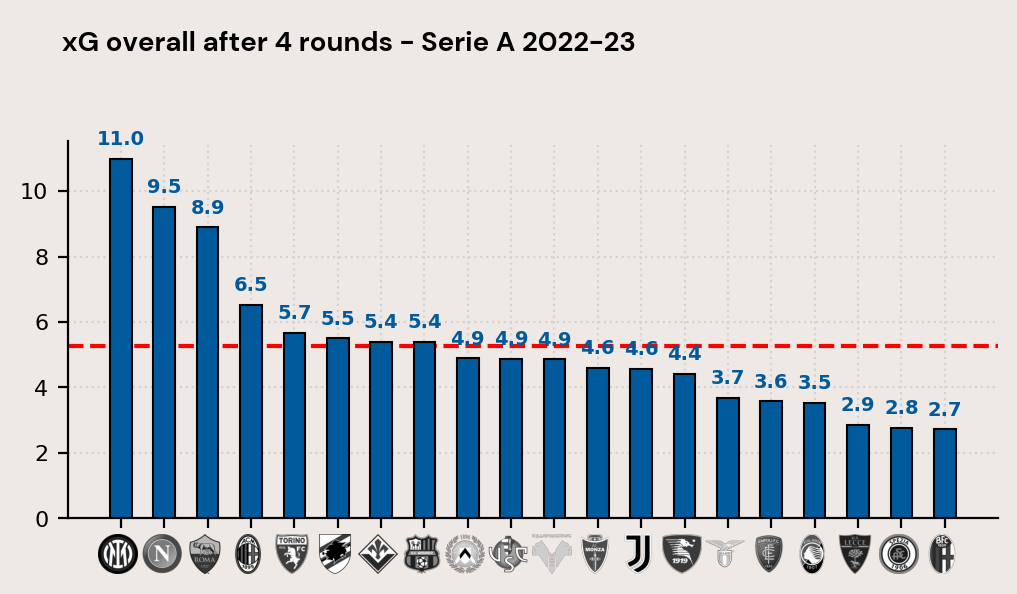

In [96]:
fig = plt.figure(figsize=(6, 2.5), dpi = 200, facecolor = "#EFE9E6")
ax = plt.subplot(111, facecolor = "#EFE9E6")

# Add spines
ax.spines["top"].set(visible = False)
ax.spines["right"].set(visible = False)

# Add grid and axis labels
ax.grid(True, color = "lightgrey", ls = ":")

# We specify the width of the bar
width = 0.5

# xG sum
ax.bar(
    X_2223,
    height_2223, 
    ec = "black", 
    lw = .75, 
    color = "#005a9b", 
    zorder = 3, 
    width = width,
    label = "xG totale"
)

ax.axhline(y=xg_2223_avg, color='red', linestyle='--', label='average')

for index, y in enumerate(height_2223):
    ax.annotate(
        xy = (index, y),
        text = f"{y:.1f}",
        xytext = (0, 7),
        textcoords = "offset points",
        size = 7,
        color = "#005a9b",
        ha = "center",
        va = "center",
        weight = "bold"
    )

xticks_ = ax.xaxis.set_ticks(
    ticks = X_2223,
    labels = []
    )

ax.tick_params(labelsize = 8)


# --- Axes transformations

DC_to_FC = ax.transData.transform
FC_to_NFC = fig.transFigure.inverted().transform

# Native data to normalized data coordinates
DC_to_NFC = lambda x: FC_to_NFC(DC_to_FC(x))

fotmob_url = "https://images.fotmob.com/image_resources/logo/teamlogo/"
for index, team_id in enumerate(data_xg_sorted["teamId"]):
    ax_coords = DC_to_NFC([index - 1.05*width, -1.7])
    logo_ax = fig.add_axes([ax_coords[0], ax_coords[1], 0.08, 0.08], anchor = "W")
    club_icon = Image.open(urllib.request.urlopen(f"{fotmob_url}{team_id:.0f}.png")).convert("LA")
    logo_ax.imshow(club_icon)
    logo_ax.axis("off")

    #logo_ax.annotate(
    #    xy =(0, 0),
    #    text = f"({sb_2122_per_team_venue_b['team'].iloc[index]})",
    #    xytext = (8, -20),
    #    textcoords = "offset points",
    #    size = 4,
    #    ha = "center",
    #    va = "center"
    #)

fig_text(
    x = 0.12, y = 1.1,
    s = "xG overall after 4 rounds - Serie A 2022-23",
    family = "DM Sans",
    weight = "bold",
    size = 10
)

plt.savefig(
	"figures/SerieA_4_22_23_xG_performance_2.png",
	dpi = 600,
	facecolor = "#EFE9E6",
	bbox_inches="tight",
    edgecolor="none",
	transparent = False
)

plt.show()